In this notebook, we want to:

- investigate the spatial structure of the residual stream
- see which tokens the different directions in the residual stream map to

# setup


In [25]:
# Generic
import os
from pathlib import Path
from copy import deepcopy
import typing
from collections import Counter

# Numerical Computing
import numpy as np
import torch
import pandas as pd
# import torch.nn.functional as F
from fancy_einsum import einsum
import einops
from jaxtyping import Float, Int, Bool

# scipy
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
# from scipy.spatial.distance import cosine

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets


# muutils
from muutils.misc import shorten_numerical_to_str
from muutils.nbutils.configure_notebook import configure_notebook
# TransformerLens imports
from transformer_lens import HookedTransformer, ActivationCache

# Our Code
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP
from maze_dataset.tokenization.token_utils import strings_to_coords, coords_to_strings
from maze_dataset.constants import _SPECIAL_TOKENS_ABBREVIATIONS

from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig
from maze_transformer.utils.dict_shapes import string_dict_shapes
from maze_transformer.mechinterp.plot_weights import plot_embeddings
from maze_transformer.mechinterp.residual_stream_structure import (
    TokenPlottingInfo, process_tokens_for_pca, EmbeddingsPCAResult, compute_pca, plot_pca_colored, 
    compute_distances_and_correlation, plot_distances_and_correlation,
)


In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)


DEVICE = device(type='cpu')


In [3]:
# path to load the model from
MODEL_PATH: str = "../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj"
# load the model and tokenizer
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read(MODEL_PATH)
num_params: int = MODEL.num_params()
print(f"loaded model with {shorten_numerical_to_str(num_params)} params ({num_params = }) from\n{MODEL_PATH}")
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer

self.tokenization_mode = <TokenizationMode.AOTP_UT_uniform: 'AOTP_UT_uniform'>
self.tokenization_mode = <TokenizationMode.AOTP_UT_uniform: 'AOTP_UT_uniform'>
loaded model with 1.3M params (num_params = 1274699) from
../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj


In [4]:
# get tokenizer and embedding info
print(f"{TOKENIZER.token_arr = }")
d_model: int = MODEL.config.d_model
print(f"{MODEL.W_E.shape = }")
assert MODEL.W_E.shape == (TOKENIZER.vocab_size, d_model)
VOCAB_TOKENS: Int[torch.Tensor, "vocab_size"] = torch.arange(TOKENIZER.vocab_size, device=DEVICE)
assert VOCAB_TOKENS.tolist() == TOKENIZER.encode(TOKENIZER.token_arr)

# maps token to (index, coordinate)
COORDINATE_TOKENS_INFO: dict[str, (int, tuple[int,int])] = {
    tok: coord
    for idx, (tok, coord) in enumerate(zip(TOKENIZER.token_arr, TOKENIZER.strings_to_coords(TOKENIZER.token_arr, when_noncoord="include")))
    if not isinstance(coord, str)
}
print(f"{COORDINATE_TOKENS_INFO = }")

# information for how to plot the tokens
VOCAB_PLOT_INFO: list[TokenPlottingInfo] = process_tokens_for_pca(TOKENIZER)

TOKENIZER.token_arr = ['<ADJLIST_START>', '<ADJLIST_END>', '<TARGET_START>', '<TARGET_END>', '<ORIGIN_START>', '<ORIGIN_END>', '<PATH_START>', '<PATH_END>', '<-->', ';', '<PADDING>', '(0,0)', '(0,1)', '(1,0)', '(1,1)', '(0,2)', '(2,0)', '(1,2)', '(2,1)', '(2,2)', '(0,3)', '(3,0)', '(3,1)', '(2,3)', '(3,2)', '(1,3)', '(3,3)', '(0,4)', '(2,4)', '(4,0)', '(1,4)', '(4,1)', '(4,2)', '(3,4)', '(4,3)', '(4,4)', '(0,5)', '(5,0)', '(5,1)', '(2,5)', '(5,2)', '(5,3)', '(4,5)', '(5,4)', '(1,5)', '(3,5)', '(5,5)', '(0,6)', '(2,6)', '(4,6)', '(6,0)', '(1,6)', '(6,1)', '(6,2)', '(3,6)', '(6,3)', '(6,4)', '(5,6)', '(6,5)', '(6,6)', '(0,7)', '(7,0)', '(7,1)', '(2,7)', '(7,2)', '(7,3)', '(4,7)', '(7,4)', '(7,5)', '(6,7)', '(7,6)', '(1,7)', '(3,7)', '(5,7)', '(7,7)']
MODEL.W_E.shape = torch.Size([75, 128])
COORDINATE_TOKENS_INFO = {'(0,0)': (0, 0), '(0,1)': (0, 1), '(1,0)': (1, 0), '(1,1)': (1, 1), '(0,2)': (0, 2), '(2,0)': (2, 0), '(1,2)': (1, 2), '(2,1)': (2, 1), '(2,2)': (2, 2), '(0,3)': (0, 3), '(3,0

# PCA of token embeddings

In [5]:
# compute the PCA
PCA_RESULTS: dict[str, EmbeddingsPCAResult] = compute_pca(
    model=MODEL,
    token_plotting_info=VOCAB_PLOT_INFO,
)

In [6]:
ipywidgets.interact(
    plot_pca_colored, 
    pca_results_options=ipywidgets.fixed(PCA_RESULTS),
    pca_results_key=ipywidgets.Dropdown(
        options=list(PCA_RESULTS.keys()),
        value='all',
        description='PCA Results:',
    ),
    vocab_colors=ipywidgets.fixed(VOCAB_PLOT_INFO), 
    dim1=ipywidgets.IntText(
        value=1,
        description='Dim 1:',
    ),
    dim2=ipywidgets.IntText(
        value=2,
        description='Dim 1:',
    ),
    lattice_connections=ipywidgets.Dropdown(
        options=[True, False],
        value=True,
        description='Show Lattice:',
    ),
    # float or None (entry box of float or text)
    symlog_scale=ipywidgets.FloatText(
        value=-1,
        description='Symlog Scale:',
    ),
    axes_and_centered=ipywidgets.Dropdown(
        options=[True, False],
        value=True,
        description='Center and show axes:',
    ),
);

interactive(children=(Dropdown(description='PCA Results:', options=('all', 'coords_only', 'special_only'), val…

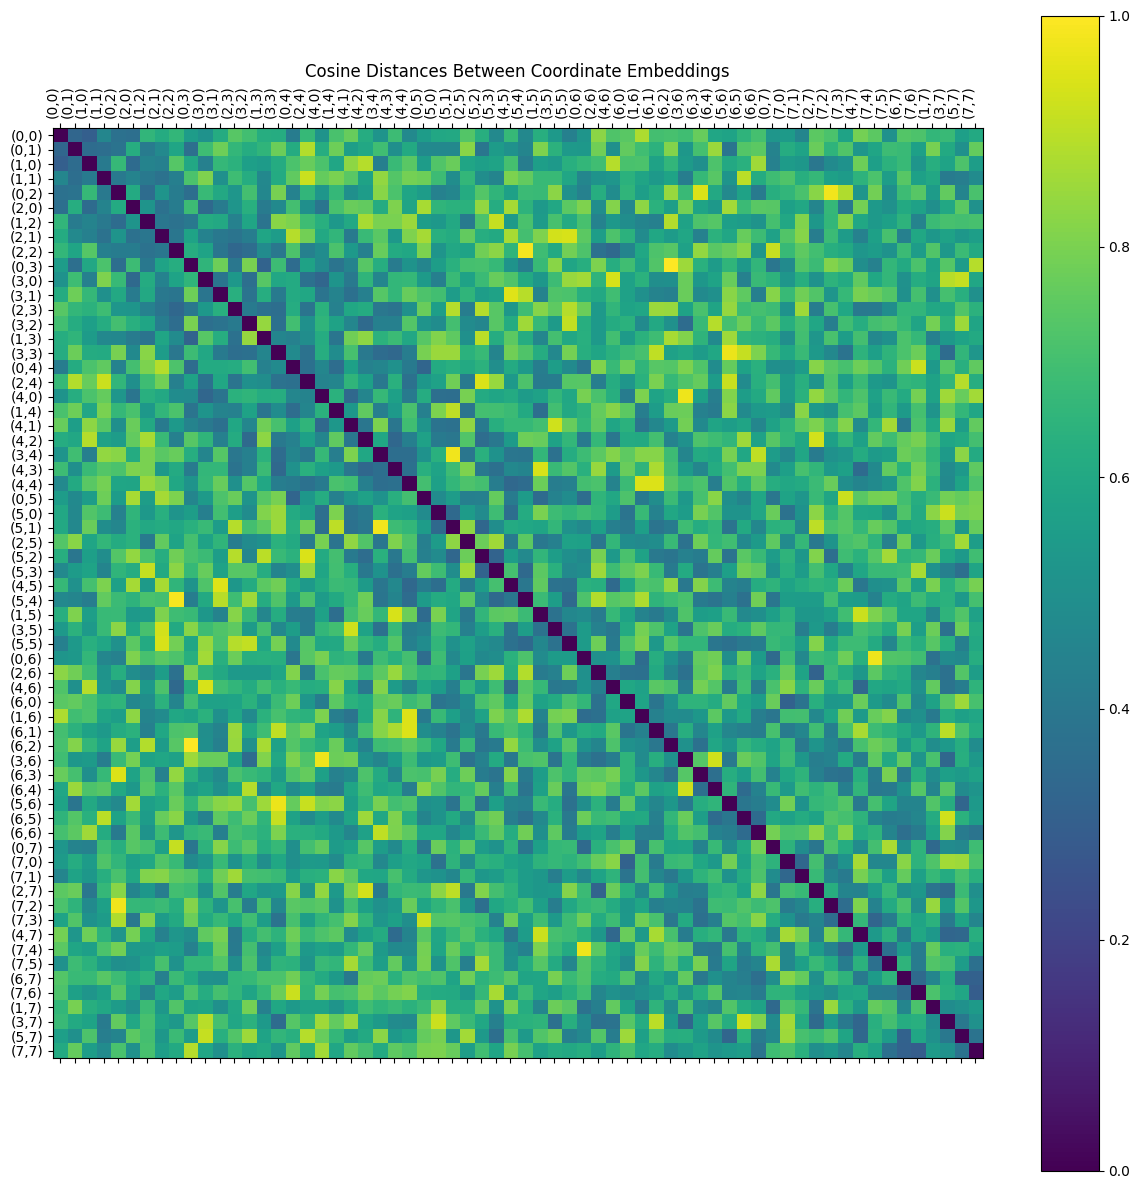

In [27]:
distances_result: dict = compute_distances_and_correlation(
    embedding_matric=MODEL.W_E.detach().cpu().numpy(),
    tokenizer=TOKENIZER,
)

In [24]:

def calculate_correlation(embedding_matrix: Float[torch.Tensor, "d_vocab d_model"], tokenizer: MazeTokenizer) -> float:
    # Filter the embeddings of the coordinate tokens
    coord_tokens_ids: dict[str, int] = tokenizer.coordinate_tokens_ids
    coord_embeddings: Float[np.ndarray, "n_coord_tokens d_model"] = np.array([
        embedding_matrix[v].numpy() 
        for v in coord_tokens_ids.values()
    ])

    # Calculate the pairwise cosine and Euclidean distances
    cosine_distances = pdist(coord_embeddings, metric='cosine')
    

correlation = calculate_correlation(MODEL.W_E.detach().cpu(), TOKENIZER)
print(f"Correlation between Euclidean distance in the coordinate space and the corresponding cosine distances: {correlation}")


Correlation between Euclidean distance in the coordinate space and the corresponding cosine distances: 0.360511955026404


In [10]:


def interleave_arrays(arrays):
    # Initialize counter
    max_counts = Counter()
    
    # Count maximum frequency of each distance across all arrays
    for array in arrays:
        counts = Counter(array)
        for k in counts:
            max_counts[k] = max(max_counts[k], counts[k])
    
    # Sort distances in increasing order and interleave them based on their maximum frequencies
    interleaved = []
    for k in sorted(max_counts.keys()):
        interleaved.extend([k] * max_counts[k])
    
    return interleaved


def sort_by_distance(coord, coord_tokens):
    def euclidean_distance(a, b):
        return np.sqrt(np.sum((np.array(a) - np.array(b)) ** 2))

    coord = np.array(eval(coord))  # Convert the string representation to an array
    sorted_tokens = sorted(coord_tokens.keys(), key=lambda x: euclidean_distance(coord, np.array(eval(x))))
    euclidean_distances = [euclidean_distance(coord, np.array(eval(x))) for x in sorted_tokens]
    return sorted_tokens, euclidean_distances

def plot_cosine_distances_ordered(embedding_matrix, vocab):
    coord_tokens = {k: v for v, k in enumerate(vocab) if k.startswith('(')}
    embedding_matrix = embedding_matrix / embedding_matrix.norm(dim=1, keepdim=True)

    sorted_coord_tokens = {}
    sorted_coord_embeddings = {}
    all_distances = {}
    for coord in coord_tokens.keys():
        sorted_tokens, euclidean_distances = sort_by_distance(coord, coord_tokens)
        all_distances[coord] = euclidean_distances
        sorted_coord_tokens[coord] = sorted_tokens
        print([vocab[token] for token in sorted_tokens])
        sorted_coord_embeddings[coord] = np.array([embedding_matrix[vocab[token]] for token in sorted_tokens])

    n = len(coord_tokens)
    all_distances_unique = interleave_arrays(all_distances.values())

    cosine_distances_matrix = np.zeros((n, len(all_distances_unique)))


    for i, coord in enumerate(coord_tokens.keys()):
        embeddings = sorted_coord_embeddings[coord]
        cosine_distances = embeddings[:1] @ embeddings.T
        cosine_distances = cosine_distances.squeeze()

        prev_col, col_increment = -1, 0
        for j, token in enumerate(sorted_coord_tokens[coord]):
            col = all_distances_unique.index(all_distances[coord][j])
            if prev_col == col:
                col_increment += 1
            else:
                col_increment = 0

            cosine_distances_matrix[i, j+col_increment] = cosine_distances[j]
            prev_col = col

    fig, ax = plt.subplots(figsize=(n*0.5, n*0.5))
    cax = ax.matshow(cosine_distances_matrix, cmap='viridis')
    # Create a custom colorbar axis that matches the height of the plot
    
    cbar_ax = fig.add_axes([0.92, 0.125, 0.03, 0.755])
    fig.colorbar(cax, cax=cbar_ax)

    # fig.colorbar(cax)

    ax.set_yticks(np.arange(n))
    ax.set_xticks(np.arange(len(all_distances_unique)))
    ax.set_xticklabels([f"{i}:.2f" for i in all_distances_unique])
    ax.set_yticklabels(coord_tokens.keys())

    # Create a separate x-axis label for each row
    for i, coord in enumerate(coord_tokens.keys()):
        ax.text(-0.5, i, coord, ha='right', va='center', fontsize=8)

    cmap_midpoint = (cosine_distances_matrix.max() - cosine_distances_matrix.min()) / 2 + cosine_distances_matrix.min()
    # Set column labels
    for i, coord in enumerate(coord_tokens.keys()):
        for j, token in enumerate(sorted_coord_tokens[coord]):
            # ax.text(j, i, token, ha='center', va='center', rotation=45, fontsize=8)
            cell_value = cosine_distances_matrix[i, j]
            text_color = 'white' if cell_value < cmap_midpoint else 'black'
            ax.text(j, i, token, ha='center', va='center', rotation=0, fontsize=10, color=text_color)
    

    ax.set_title('Cosine Distances Between Coordinate Embeddings Ordered by Distance')
    plt.savefig('results/cosine_distances_ordered.png', bbox_inches='tight', dpi=200)
    plt.show()

plot_cosine_distances_ordered(MODEL.W_E.detach().cpu(), TOKENIZER.token_arr)

TypeError: list indices must be integers or slices, not str

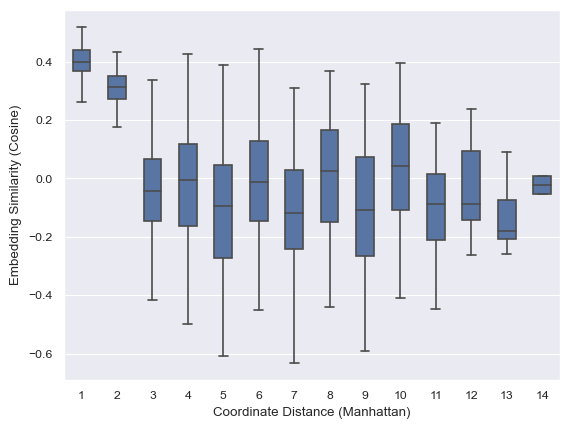

In [28]:


def euclidean_distance(a, b):
    # manhattan
    return np.sum(np.abs(np.array(a) - np.array(b)))

def get_euclidean_distances(coord_tuples):
    distances = []
    for i, coord1 in enumerate(coord_tuples):
        row_distances = []
        for j, coord2 in enumerate(coord_tuples):
            row_distances.append(euclidean_distance(coord1, coord2))
        distances.append(row_distances)
    return np.array(distances)

# Visualize cartesian distance vs cosine distance
sns.set_theme('paper')
def plot_cartesian_vs_cosine_distances(normed_w_e, vocab):
    coords_in_order = [eval(coord) for coord in vocab.keys()] # same order as rows in normed_w_e
    # embed_distances = cdist(normed_w_e, normed_w_e, p=1.0) # L2 of each row with normalization => cosine
    embed_distances = normed_w_e @ normed_w_e.T # cosine distance
    euclid_distances = get_euclidean_distances(coords_in_order)

    x = []
    y = []
    for row_idx in range(normed_w_e.shape[0]):
        source_coord = coords_in_order[row_idx]

        cosine_distances = embed_distances[row_idx].detach().cpu().numpy()
        euclidean_distances = euclid_distances[row_idx]

        # remove self
        cosine_distances = np.delete(cosine_distances, row_idx)
        euclidean_distances = np.delete(euclidean_distances, row_idx)

        x.extend(euclidean_distances.tolist())
        y.extend(cosine_distances.tolist())
    

    sns.boxplot(x=x, y=y, color=sns.color_palette()[0], showfliers=False, width=0.5)
    # sns.violinplot(x=x, y=y, color=sns.color_palette()[0])
    # plt.xticks(np.arange(1, euclid_distances.max()+1, 1)
    plt.xlabel('Coordinate Distance (Manhattan)')
    plt.ylabel('Embedding Similarity (Cosine)')
    # plt.savefig('results/geometry/cartesian_vs_cosine_distances.png', bbox_inches='tight', dpi=200)

# Split W_E to only include coords
filtered_vocab = {k: v for k, v in MODEL.tokenizer.vocab.items() if k not in [*MODEL.tokenizer.additional_special_tokens, MODEL.tokenizer.pad_token, MODEL.tokenizer.unk_token]}
filtered_w_e = MODEL.W_E[[v for k, v in filtered_vocab.items()]]
filtered_w_e /= filtered_w_e.norm(dim=1)[:, None]
plot_cartesian_vs_cosine_distances(filtered_w_e, filtered_vocab)